<a href="https://colab.research.google.com/github/GongYangrui/CSLearning/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring `RAPS`
This is a colab that shows you how to generate predictive sets guaranteed to contain the true class label with a probability you specify.

This technique was proposed in our work [Uncertainty Sets for Image Classifiers using Conformal Prediction](https://arxiv.org/abs/).

## Setting up the experiments

**Make sure you're using a GPU** by setting "Runtime/Change runtime type/Hardware accelerator/" to "GPU" in the colab menu above.  

First, let's deal with imports, loading the pretrained model, and other boilerplate.

In [1]:
!rm -r conformal_classification
!git clone https://github.com/aangelopoulos/conformal_classification.git
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], './conformal_classification/'))

from conformal import *
from utils import *

# Import other standard packages
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.backends.cudnn as cudnn
import random

# Fix the random seed for reproducibility (you can change this, of course)
seed=0
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

cudnn.benchmark = True
batch_size = 128

# Get your model
model = torchvision.models.resnet152(pretrained=True,progress=True).cuda()
_ = model.eval()

rm: cannot remove 'conformal_classification': No such file or directory
Cloning into 'conformal_classification'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 626 (delta 0), reused 1 (delta 0), pack-reused 623 (from 1)
Receiving objects: 100% (626/626), 4.36 MiB | 2.14 MiB/s, done.
Resolving deltas: 100% (412/412), done.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 172MB/s]


Now download and extract ImageNet-Val. You only need to execute this cell once and it takes less than 5 minutes to run on my system.

In [2]:
!wget -nv -O imagenet_val.tar.gz -L https://berkeley.box.com/shared/static/pouthcomrvxw9hj64oxhacjvqdw3ihlp.gz
!mkdir imagenet_val
!tar -xf imagenet_val.tar.gz -C ./imagenet_val/
!mv imagenet_val/scratch/group/ilsvrc/val/* imagenet_val/
!rm -r imagenet_val/scratch

2025-03-03 01:31:05 URL:https://public.boxcloud.com/d/1/b1!NY1ASn2K-AyDENwULgoJHpZVFMtAMp7haN4WUzW7MV8nydYoORR7U8a_gYbQFLpq2goP-49CcayZ4Z07Ax1_Gscfrc723F9vggF9dIL-NZCsdzaQW2nFG4O0H_Lmq1sn3nfIh9NBhT-mvUWW76kkfWI5hIBhcepk-BUh5vaaIMIWDHofWv-BB89_9tNttsxiX9ShYGM6p6LBlTGzL86EDrpRPc_4ZdT0HmeibIItfMcjyDy-WG3UNNglfsBDHD-u78-KtyB5Ya7Wd2I4NsBhGcJUEUocV7VV4lxSp8FnyCbzPrafW_nmObs3zPMsOBhK54ZmBJasTaRXy5IirfGBblaEb_L9stiqsQME_fk_JTF-SWRtxn2BRT0vVo229VAYJkiOK_NshNTWSK-WpSPqMYPLX2Y7tllYRHNNSZngEYTEHGLLxijw7U96Yqze3YRyH--UpvXF0IdF1dqTOBOkw0UNBhCNw9SFJbySKPaAzAiqPNxkkKydqErvJxy3wNABPQtctSuNpK0IyZ5BU-OOnhoMI20ctXxXQAJ9xaOSTXnpIIsK078736erFy8p3sOOMGtfx_iQJbOR3BQ_bSVtA1nnmsXF9c29WIDq9QcvSWJlOQc99B-_ldiciupTPQQZ90wmP9w0Ryciz5pDFHEFBDKMNra21mYkZ-DjOrs5kwr3VF7G9QP1-XYmyCInzqv_WAP-MqOA_FXxmMpnLlze6TsCBW_57Nopvk9ORJ2LExQH7mjJrtyZia8MZobtUOwQUocZS2wjB9gMFzv6HY6qAQCv2qMWf5aonlTYM0JZZwBh-xJzDdG9Hf9MdJ108m07cU50f2Yza_8fP0499uu0kxD2xHMbcFkUDTSU-eUnu6OLrwzl8zZ76nzgyx4ENYtmQXFV0mHo8sGw4ROBSEQuMEkzCdYxw8uCyaPkYRTMvm6Mq

Now get the conformal calibration set and the validation dataset.

In [3]:
num_calib = 5000

# Get the conformal calibcration dataset
imagenet_calib_data, imagenet_val_data = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./imagenet_val/', transform), [num_calib,50000-num_calib])

# Initialize loaders
calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)



## Conformalizing the model

This this the key step, where you perform Platt scaling and then wrap the model with `RAPS`.

 *(Did you catch the joke?)*

You should experiment with different values of `alpha` and `lamda_criterion`=`'size'` or `'adaptiveness'` to see how the sets change.

In [7]:
# Conformalize model
cmodel = ConformalModel(model, calib_loader, alpha=0.1, lamda_criterion='size')

Begin Platt scaling.
Computing logits for model (only happens once).


  5%|▌         | 2/40 [00:04<01:23,  2.20s/it]


KeyboardInterrupt: 

**Congratulations!** You can now output `1-alpha` predictive sets.


Now you can validate the coverage of your conformal model on the validation set with this utility function.

Running averages of coverage and size are in parentheses.

**Feel free to stop execution of this cell at any time**; otherwise it will run until `N=50,000-num_calib`, since that's the size of the validation set.

In [5]:
top1, top5, coverage, size = validate(val_loader, cmodel, print_bool=True)

N: 3328 | Time: 1.983 (2.035) | Cvg@1: 0.781 (0.786) | Cvg@5: 0.938 (0.941) | Cvg@RAPS: 0.914 (0.910) | Size@RAPS: 2.008 (2.167)

KeyboardInterrupt: 

That's it! You're ready to use RAPS.

As a final visualization, running the next cell will just sample random 5 images and show their RAPS sets. Note that you can avoid sets of size zero by setting `randomized=False`.

It's interesting to see which images the model thinks are more difficult.

2025-03-03 01:35:08 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14209/14209] -> "human_readable_labels.json" [1]
Image 0 has label 'fountain', and the predictive set is ['fountain'].
Image 1 has label 'goose', and the predictive set is ['goose', 'black swan', 'American coot'].
Image 2 has label 'Airedale Terrier', and the predictive set is ['Border Terrier', 'Norfolk Terrier', 'Australian Terrier'].
Image 3 has label 'mixing bowl', and the predictive set is ['mixing bowl', 'teapot', 'soup bowl'].
Image 4 has label 'meerkat', and the predictive set is ['meerkat', 'mongoose'].
Image 5 has label 'swimming cap', and the predictive set is ['swimming cap', 'swing', 'chain'].
Image 6 has label 'Old English Sheepdog', and the predictive set is ['Old English Sheepdog'].
Image 7 has label 'black stork', and the predictive set is ['black stork', 'oystercatcher', 'white stork'].


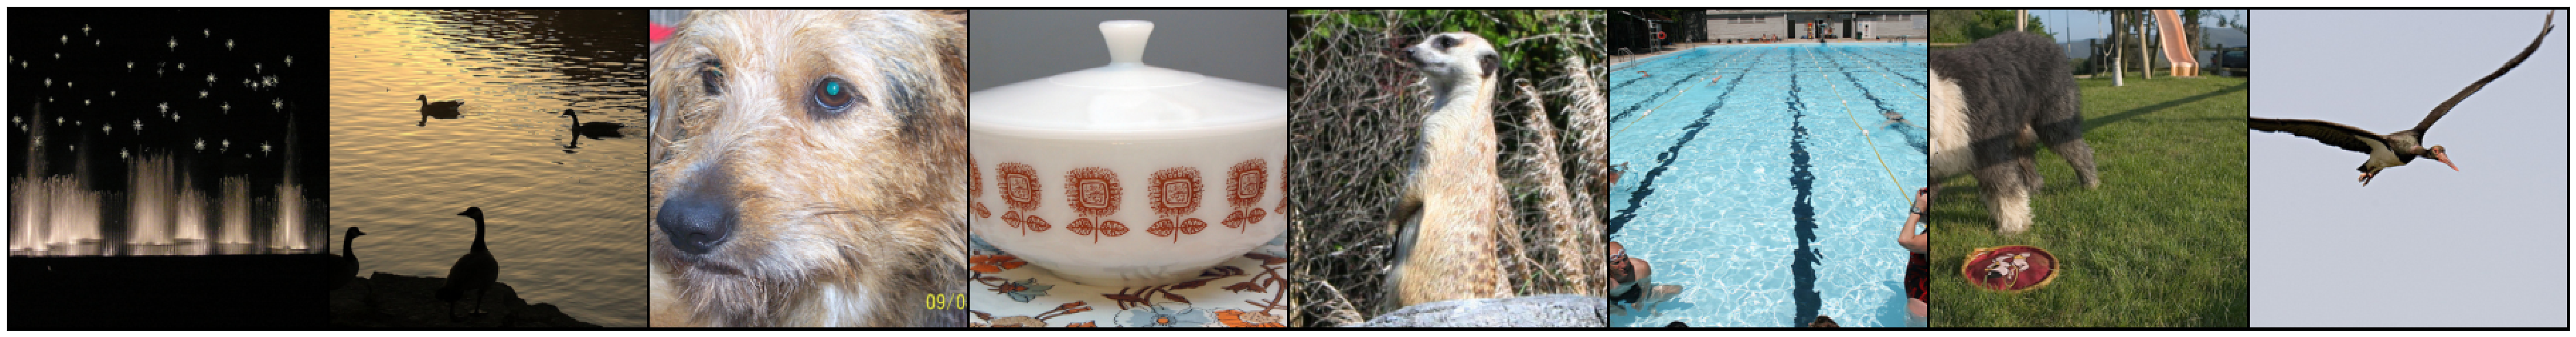

In [6]:
num_images = 8
explore_data, _ = torch.utils.data.random_split(imagenet_val_data, [num_images, 50000-num_calib-num_images])

import pdb
import json

!wget -nv -O human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

with open('human_readable_labels.json') as f:
    labels = json.load(f)

labeldict = {}
for i in range(len(labels)):
  labeldict[i] = labels[i]

mosaiclist = []
sets = []
labels = []

for data in explore_data:
  img, label = data
  scores, set = cmodel(img.view(1,3,224,224).cuda())
  unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)

  set = [labeldict[s] for s in set[0]]
  sets = sets + [set]
  labels = labels + [labeldict[label]]
  mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images,9)*5, np.floor(num_images/9+1)*5))
ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
  print(f"Image {i} has label \'{labels[i]}\', and the predictive set is {sets[i]}.")
